# Train a simple reference network

Credit: Sebastian Scher

In [21]:
%load_ext autoreload
%autoreload 2

In [22]:
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import tensorflow as tf
import tensorflow.keras as keras
import seaborn as sns
from src.score import *

In [2]:
def limit_mem():
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    tf.Session(config=config)

In [3]:
limit_mem()

In [4]:
sns.set_style('darkgrid')
sns.set_context('notebook')

In [5]:
DATADIR = '/data/weather-benchmark/5.625deg/geopotential_500/'

## Load and preprocess dataset

In [6]:
z500 = xr.open_mfdataset(f'{DATADIR}*')

In [7]:
z500.load()

<xarray.Dataset>
Dimensions:  (lat: 33, lon: 64, time: 350640)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 1979-01-01 ... 2018-12-31T23:00:00
Data variables:
    z        (time, lat, lon) float32 51486.617 51486.617 ... 48530.29 48530.29
Attributes:
    Conventions:  CF-1.6
    history:      2019-09-18 08:52:54 GMT by grib_to_netcdf-2.10.0: /opt/ecmw...

In [8]:
data_train = z500.z.sel(time=slice(None, '2016'))
data_test = z500.z.sel(time=slice('2017', '2018'))

In [9]:
# Compute mean and std for normalization
data_mean = data_train.mean()
data_std = data_train.std('time').mean()
data_mean, data_std

(<xarray.DataArray 'z' ()>
 array(53986.88, dtype=float32), <xarray.DataArray 'z' ()>
 array(1132.5045, dtype=float32))

In [10]:
# Normalize datasets
data_train = (data_train - data_mean) / data_std
data_test = (data_test - data_mean) / data_std

In [11]:
lead_time_h = 6

In [12]:
X_train = data_train.isel(time=slice(0, -lead_time_h))
y_train = data_train.isel(time=slice(lead_time_h, None))

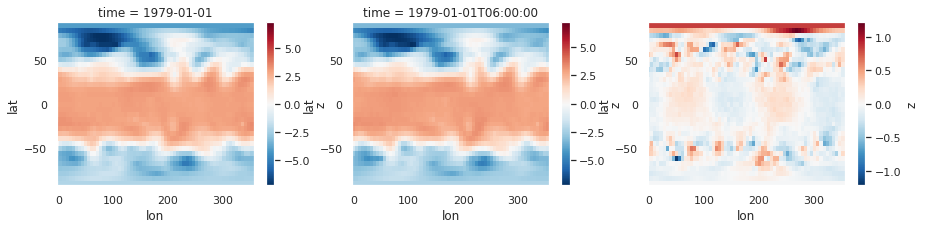

In [13]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
X_train.isel(time=0).plot(ax=ax1)
y_train.isel(time=0).plot(ax=ax2);
(y_train.isel(time=0) -X_train.isel(time=0)).plot(ax=ax3);

In [14]:
# Convert to numpy arrays
X_train = X_train.values
y_train = y_train.values

In [15]:
nsamples, nlat, nlon = X_train.shape
nsamples, nlat, nlon

(333114, 33, 64)

## Train a simple dense neural network

In [48]:
from tensorflow.keras.layers import *

In [49]:
hidden_size = 1862

In [50]:
net = tf.keras.models.Sequential([
    Flatten(input_shape=(nlat, nlon)),
    Dense(hidden_size, 'relu'),
    Dense(hidden_size, 'relu'),
    Dense(hidden_size, 'relu'),
    Dense(hidden_size, 'relu'),
    Dense(nlat*nlon, 'linear'),
    Reshape((nlat,nlon))
])

In [51]:
optim = tf.keras.optimizers.Adam(lr=1e-3)

In [52]:
net.compile(optim, 'mse')

In [54]:
net.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 2112)              0         
_________________________________________________________________
dense (Dense)                (None, 1862)              3934406   
_________________________________________________________________
dense_1 (Dense)              (None, 1862)              3468906   
_________________________________________________________________
dense_2 (Dense)              (None, 1862)              3468906   
_________________________________________________________________
dense_3 (Dense)              (None, 1862)              3468906   
_________________________________________________________________
dense_4 (Dense)              (None, 2112)              3934656   
_________________________________________________________________
reshape (Reshape)            (None, 33, 64)            0

In [81]:
net.fit(X_train, y_train, epochs=200, batch_size=32,
        validation_split=0.1,
        callbacks=[tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            min_delta=0,
            patience=3,
            verbose=1, 
            mode='auto'
        )]
)

Train on 299802 samples, validate on 33312 samples
Epoch 1/200
299802/299802 [==============================] - 67s 222us/sample - loss: 0.2412 - val_loss: 0.3302
Epoch 2/200
299802/299802 [==============================] - 67s 222us/sample - loss: 0.2355 - val_loss: 0.3300
Epoch 3/200
299802/299802 [==============================] - 68s 228us/sample - loss: 0.2318 - val_loss: 0.3326
Epoch 4/200
299802/299802 [==============================] - 67s 225us/sample - loss: 0.2291 - val_loss: 0.3335
Epoch 5/200
299802/299802 [==============================] - 68s 227us/sample - loss: 0.2268 - val_loss: 0.3376
Epoch 00005: early stopping


In [82]:
net.save('./dense.h5')

## Create predictions

In [83]:
net = tf.keras.models.load_model('./dense.h5')

In [84]:
max_lead_time_h = 5*24
max_fc_steps = max_lead_time_h // lead_time_h
max_fc_steps

20

In [85]:
data_test

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
array([[[-2.772719, -2.772719, ..., -2.772719, -2.772719],
        [-2.817852, -2.768056, ..., -2.921149, -2.868601],
        ...,
        [-2.571951, -2.543243, ..., -2.630329, -2.598651],
        [-2.482641, -2.482641, ..., -2.482641, -2.482641]],

       [[-2.769329, -2.769329, ..., -2.769329, -2.769329],
        [-2.814672, -2.768004, ..., -2.913733, -2.863144],
        ...,
        [-2.573751, -2.542608, ..., -2.641346, -2.603311],
        [-2.500863, -2.500863, ..., -2.500863, -2.500863]],

       ...,

       [[-3.549458, -3.549458, ..., -3.549458, -3.549458],
        [-4.000619, -3.937664, ..., -4.139132, -4.067013],
        ...,
        [-4.448551, -4.583467, ..., -4.221824, -4.325862],
        [-4.825036, -4.825036, ..., -4.825036, -4.825036]],

       [[-3.55071 , -3.55071 , ..., -3.55071 , -3.55071 ],
        [-4.006972, -3.938653, ..., -4.154857, -4.079092],
        ...,
        [-4.40637 , -4.544987, ..., -4.185269, -

In [86]:
fcs = []
state = data_test.values
for fc_step in range(max_fc_steps):
    state = net.predict(state, batch_size=512)
    fcs.append(state * data_std.values + data_mean.values)

In [87]:
fcs = xr.DataArray(
    np.array(fcs), 
    dims=['lead_time', 'time', 'lat', 'lon'],
    coords={
        'lead_time': np.arange(lead_time_h, max_lead_time_h + lead_time_h, lead_time_h),
        'time': data_test.time,
        'lat': data_test.lat,
        'lon': data_test.lon
    }
)

In [88]:
fcs

<xarray.DataArray (lead_time: 20, time: 17520, lat: 33, lon: 64)>
array([[[[50565.51 , ..., 50565.52 ],
         ...,
         [51184.08 , ..., 51184.074]],

        ...,

        [[49511.89 , ..., 49511.914],
         ...,
         [48590.844, ..., 48590.82 ]]],


       ...,


       [[[48190.4  , ..., 48190.277],
         ...,
         [49180.734, ..., 49180.664]],

        ...,

        [[47109.79 , ..., 47109.723],
         ...,
         [50683.816, ..., 50683.7  ]]]], dtype=float32)
Coordinates:
  * lead_time  (lead_time) int64 6 12 18 24 30 36 42 ... 90 96 102 108 114 120
  * time       (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
  * lat        (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 78.75 84.38 90.0
  * lon        (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4

In [89]:
z500_valid = load_test_data(DATADIR)

In [90]:
z500_valid

<xarray.DataArray 'z' (time: 17520, lat: 33, lon: 64)>
dask.array<shape=(17520, 33, 64), dtype=float32, chunksize=(8760, 33, 64)>
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -90.0 -84.38 -78.75 -73.12 ... 73.12 78.75 84.38 90.0
  * time     (time) datetime64[ns] 2017-01-01 ... 2018-12-31T23:00:00
Attributes:
    units:          m**2 s**-2
    long_name:      Geopotential
    standard_name:  geopotential

In [91]:
rmses = []
for lead_time in fcs.lead_time:
    fc = fcs.sel(lead_time=lead_time)
    fc['time'] = fc.time + np.timedelta64(int(lead_time), 'h')
    rmses.append(compute_weighted_rmse(fc, z500_valid).values)

In [92]:
rmses

[array(626.29968406),
 array(652.20416434),
 array(693.13335824),
 array(743.0203464),
 array(798.01489928),
 array(855.05534622),
 array(912.51262081),
 array(969.47515037),
 array(1025.17374751),
 array(1078.88889995),
 array(1130.39839656),
 array(1180.5959125),
 array(1228.75259844),
 array(1275.78456687),
 array(1322.63704217),
 array(1369.00625054),
 array(1415.32765408),
 array(1461.2073774),
 array(1504.37562607),
 array(1546.02195933)]

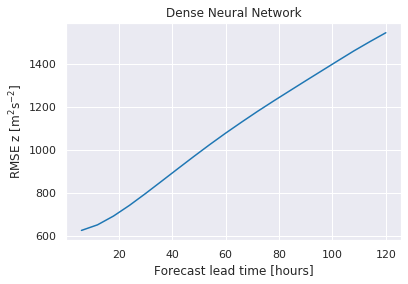

In [93]:
plt.plot(fcs.lead_time, rmses)
plt.ylabel(r'RMSE z [m$^2$s$^{-2}$]')
plt.xlabel('Forecast lead time [hours]')
plt.title('Dense Neural Network');

In [94]:
fcs.time[0]

<xarray.DataArray 'time' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01
Attributes:
    long_name:  time

In [95]:
z500_valid.time[0]

<xarray.DataArray 'time' ()>
array('2017-01-01T00:00:00.000000000', dtype='datetime64[ns]')
Coordinates:
    time     datetime64[ns] 2017-01-01
Attributes:
    long_name:  time

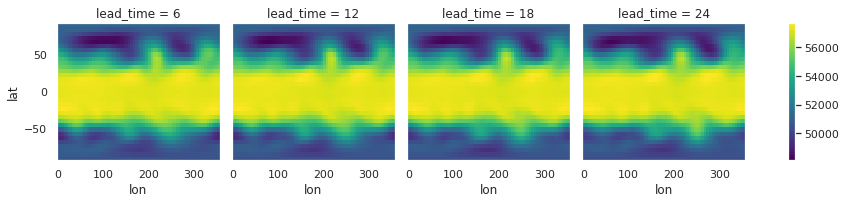

In [96]:
fcs.isel(time=0, lead_time=slice(0, 4)).plot(col='lead_time')

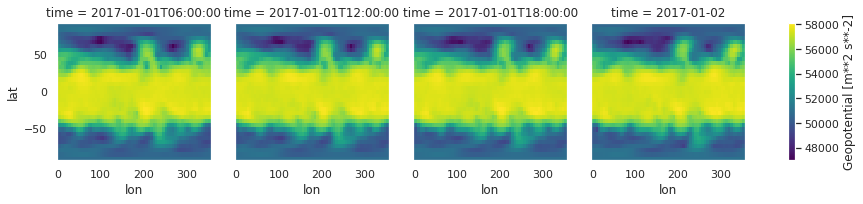

In [97]:
z500_valid.isel(time=slice(6, 6*4+6, 6)).plot(col='time')